<a href="https://colab.research.google.com/github/ilqxa/edu_optimal_control/blob/main/notebooks/control_point_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Методы безусловной оптимизации

Контрольная работа №1 по дисциплине "Оптимальное управление"  

ЯГТУ ЗА-44

In [16]:
from typing import Callable

import pandas as pd
import numpy as np
from scipy.optimize import minimize

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [17]:
#import plotly.io as pio
#pio.renderers.default = 'colab'

## Одномерная оптимизация
  
Вариант 6:
* оптимизируемая функция $f(x) = e^x$  
* диапазон поиска $x∈[0, 100]$  

Численный метод одномерной оптимизации: метод равномерного поиска  

In [31]:
step = 0.01
x = np.arange(0, 100+step, step)
x.shape

(10001,)

In [78]:
def f(x):
    return np.exp(x)

In [30]:
y = f(x)
y.shape

(10001,)

In [26]:
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=['Linear y axis', 'Log y axis'],
)

fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        # log_y=False,
        mode='lines',
        name='Linear',
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        # log_y=True,
        mode='lines',
        name='Log',
    ),
    row=1,
    col=2,
)
fig.update_yaxes(type='log', row=1, col=2)

fig.update_layout(title_text="Researched func", showlegend=False)
fig.show()

### Аналитический способ

#### Необходимое условие

Если дифференцируемая функция $y=f(x)$ имеет в точке $x=x_0$ экстремум, то ее производная в этой точке обращается в нуль.

### Численный способ

Метод равномерного поиска (метод сканирования)

Материалы:
*   Васильков, Василькова - "Метод сканирования", с. 112
*   Пантелеев, Летова - "5.1.2 Метод равномерного поиска", с. 110

In [135]:
# Точность ширины интервала
eps = 0.05

#### Шаг 1
Зададим начальный интервал неопределенности $L_0=[a_0,b_0]$, $N$ - количество вычислений функции.

Найдем начальный интервал методом Свенна [Пантелеев, Летова - замечаниие 5.2.2]

In [63]:
def swann_interval(x0: float, t: float, f: Callable) -> tuple[float, float]:
    # Принимаем начальную точку и шаг
    x = [x0]
    # Положим
    k = 0

    # Вычислим значение в трех точках
    p1, p2, p3 = f(x[0]-t), f(x[0]), f(x[0]+t)

    # Проверим условие окончания
    if p1 >= p2 <= p3:
        print('Выполнено условие p1 >= p2 <= p3')
        # Начальный интервал найден
        return (x[0] - t, x[0] + t)
    elif p1 >= p2 >= p3:
        print('Выполнено условие p1 >= p2 >= p3')
        # Параметры для продолжения поиска
        delt = t
        a0 = x[0]
        x.append(x[0])
        k = 1
    elif p1 <= p2 <= p3:
        print('Выполнено p1 <= p2 <= p3')
        # Параметры для продолжения поиска
        delt = -t
        b0 = x[0]
        x.append(x[0])
        k = 1
    else:
        # Функция не является унимодальной
        raise Exception('Интервал не может быть найден')

    # Зададим в цикле процедуру поиска
    while True:
        print(f'Цикл поиска, итерация номер {k}')
        # Найдем следующую точку
        x.append(x[k] + 2**k*delt)
        # Проверим условие убывания функции
        if f(x[k+1]) < f(x[k]):
            # Переопределим параметры
            if delt == t:
                a0 = x[k]
            elif delt == -t:
                b0 = x[k]
            # Положим
            k = k + 1
        elif f(x[k+1]) >= f(x[k]):
            break

    # При завершении поиска положим
    if delt == t:
        b0 = x[k+1]
    elif delt == -t:
        a0 = x[k+1]

    # Возвращаем найденный интервал
    return (a0, b0)

In [64]:
swann_interval(50, 20, f)

Выполнено p1 <= p2 <= p3
Цикл поиска, итерация номер 1
Цикл поиска, итерация номер 2
Цикл поиска, итерация номер 3
Цикл поиска, итерация номер 4
Цикл поиска, итерация номер 5
Цикл поиска, итерация номер 6


(-2470, -550)

Алгоритм Свенна смещает интервал в сторону минус бесконечности и упирается в предел возможности компьютерной обработки числовых значений. Примем за начальный интервал весь заданный интервал $x∈[0, 100]$, количество вычислений $N$ определим из данного предела точности

In [73]:
# Начальный интервал неопределенности
L_0 = [0, 100]
N = int((L_0[1] - L_0[0]) / eps)
N

2000

#### Шаг 2
Определим точки вычисления функции $x_i=0+i\cdot \frac{(b_0-a_0)}{N}$

In [91]:
x = [0 + i * (L_0[1] - L_0[0]) / N for i in range(N+1)]
len(x)

2001

#### Шаг 3
Вычислим значения функции в точках

In [96]:
y = f(x)
y.shape

(2001,)

#### Шаг 4
Найдем точку с наименьшим значением функции

In [98]:
# Номер точки с наименьшим значением
i = np.argmin(y)
print(
    f'Наименьшее значение достигается в точке номер {i}\n',
    f'Значение аргумента в этой точке x={x[i]}\n',
    f'Значение функции в этой точке y={y[i]}',
)

Наименьшее значение достигается в точке номер 0
 Значение аргумента в этой точке x=0.0
 Значение функции в этой точке y=1.0


### Программный способ
Применим наиболее метод minimize модуля optimize наиболее распространенного пакета численной оптимизации SciPy для Python
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [134]:
minimize(fun=f, x0=50, bounds=[(0, 100)])

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 1.0
        x: [ 0.000e+00]
      nit: 1
      jac: [ 1.000e+00]
     nfev: 4
     njev: 2
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

## Многомерная безусловная оптимизация

Вариант 6:
* Вид целевой функции $f(x_1,x_2)=x_1^3+x_2^2-6x_1x_2-39x_1+18x_2+20$  
* Начальная точка: $x_1=15, x_2=18$  
* Точность: $ε=0.1$  

Метод многомерной оптимизации: градиентный метод с дроблением шага

In [24]:
x_left = -200
x_right = 200
step = 1

x1 = np.arange(x_left, x_right, step)
x2 = np.arange(x_left, x_right, step)
print(
    x1.shape,
    x2.shape
)

(400,) (400,)


In [25]:
def f(x1, x2):
    return x1**3 + x2**2 - 6*x1*x2 - 39*x1 + 18*x2 + 20

In [26]:
y = f(*np.meshgrid(x1, x2))
y.shape

(400, 400)

In [27]:
fig = go.Figure(
    data=[
        go.Surface(
            x=x1,
            y=x2,
            z=y,
        )
    ],
)

fig.update_layout(
    title='Researched func',
    scene={
        'xaxis_title': 'x1',
        'yaxis_title': 'x2',
        'zaxis_title': 'y',
    }
)

fig.show()

### Аналитический способ

### Графический анализ

https://www.wolframalpha.com/input?i=solve+f%28x1%2C+x2%29%3Dx1%5E3+%2B+x2%5E2+-+6*x1*x2+-+39*x1+%2B+18*x2+%2B+20+for+x2
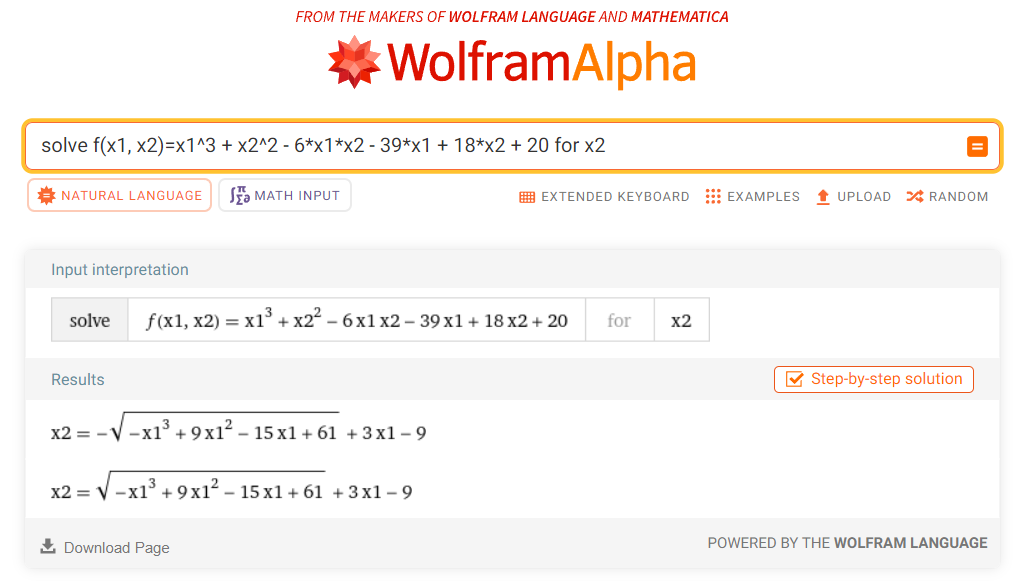

### Численный способ